# IMDB Movie review sentiment analysis

## Introduction

Given the huge volume of users review data. Sentiment Analysis has become top most priority under Natural Language Processing domain to determine the polarity of small piece of text written by the users. This project aims in finding whether the given review is either  being positive or negative.

## Description of the Data set

The dataset was obtained from [Stanford AI library](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz). It consists of 50000 movie reviews from IMDB, and there are no more than 30 reviews per movie. The dataset consists of  equal number of positive and negative reviews. Negative reviews have scores less or equal than 4 out of 10 while a positive review have score greater or equal than 7 out of 10.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [127]:
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



from textblob import TextBlob

In [112]:
def data_process(inpath,outpath="./",name="train_i.csv",mix=False):
    import pandas as pd
    import numpy as np
    import os
    
    
    indices=[]
    text=[]
    rating=[]
    
    i=0
    
    for filename in os.listdir(inpath+"pos"):
        data = open(inpath+"pos/"+filename, 'r' , encoding="ISO-8859-1").read()
        
        indices.append(i)
        text.append(data)
        rating.append("1")
        i = i + 1
        
    for filename in os.listdir(inpath+"neg"):
        data = open(inpath+"neg/"+filename, 'r' , encoding="ISO-8859-1").read()
        
        indices.append(i)
        text.append(data)
        rating.append("0")
        i = i + 1
        

    Dataset = list(zip(indices,text,rating))

    if mix:
        np.random.shuffle(Dataset)
    
    df = pd.DataFrame(data = Dataset, columns=['row_Number', 'text', 'polarity'])
    df.to_csv(outpath+name, index=False, header=True)

    pass


In [113]:
data_process("aclImdb/train/",outpath="./",name="train.csv",mix=False)

In [114]:
data_process("aclImdb/test/",outpath="./",name="test.csv",mix=False)

## Reading the data

In [115]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [116]:
train.head()

,row_Number,text,polarity
0,0,For a movie that gets no respect there sure ar...,1
1,1,Bizarre horror movie filled with famous faces ...,1
2,2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,3,It's a strange feeling to sit alone in a theat...,1
4,4,"You probably all already know this by now, but...",1


In [117]:
train=train.drop("row_Number",axis=1)
test=test.drop("row_Number",axis=1)


In [118]:
train.head()


,text,polarity
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [119]:
print(train.shape)
print(test.shape)

(25000, 2)
(25000, 2)


In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
text        25000 non-null object
polarity    25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


### Are there any duplicates present in the dataset ?

In [121]:
train.duplicated().sum()

96

In [122]:
test.duplicated().sum()

199

There are 96 duplicates in the  train dataset and 199 duplicates in the test dataset. First we need to remove those duplicates from the data.

In [123]:
train_1=train.drop_duplicates(keep="first",inplace=False)
test_1=test.drop_duplicates(keep="first",inplace=False)

In [124]:
train_1.duplicated().sum()

0

In [125]:
test_1.duplicated().sum()

0

## Feature Engineering

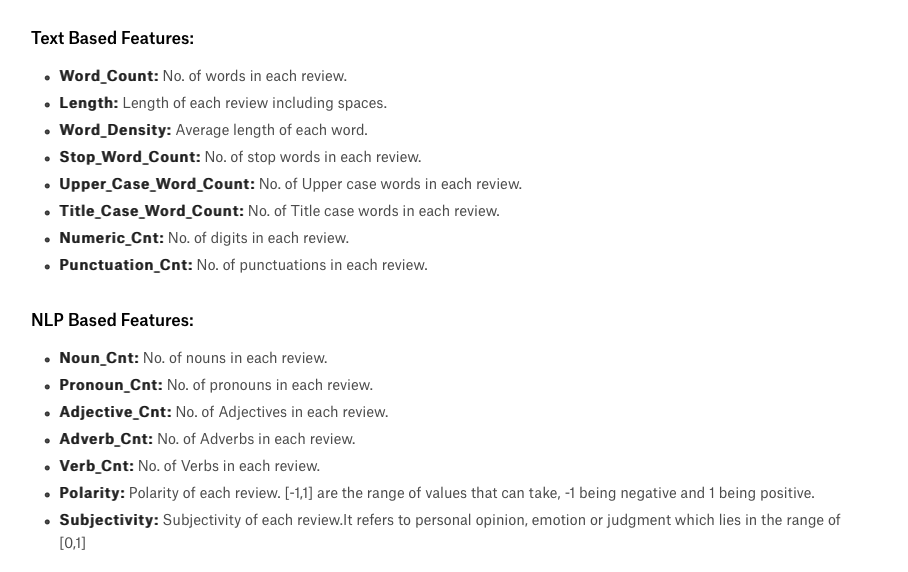


Using textblob we are obtaining subjectivity,polarity and pos tagging. Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. For more information about the text blob please go thorugh [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)

In [134]:
# defining functions for polarity, subjectivity and parts of speech counts

stop_words=stopwords.words("english")
def get_polarity(text):
    try:
        tb=TextBlob(str(text))
        polarity=tb.sentiment.polarity
    except:
        polarity=0.0
    return polarity


def get_subjectivity(text):
    try:
        tb=TextBlob(str(text))
        subjectivity=tb.sentiment.subjectivity
    except:
        subjectivity=0.0
    return subjectivity

pos_dict = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pronoun' : ['PRP','PRP$'],
    'adjective' : ['JJ','JJR','JJS'],
    'adverb' : ['RB','RBR','RBS','WRB'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ']
           }

def get_pos(text,pos):
    count=0
    try:
        tokens=nltk.word_tokenize(text)
        for tag in nltk.pos_tag(tokens):
            if tag[1] in pos_dict[pos]:
                count=count+1
        return count
    except:
        pass

In [136]:
# function for extracting features:

def extract_text_features(df):
    df["word_count"]=df['text'].apply(lambda x:len(str(x).split()))
    df["length"]=df['text'].apply(len)
    df["word_density"]=df["word_count"]/df["length"]
    df["stop_word_count"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word in stop_words]))
    df["uppercase_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
    df["titlecase_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))
    df["numeric_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))
    df["punctuation_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word in string.punctuation]))
    
    
    df["Noun_count"]=df["text"].apply(lambda x:get_pos(str(text,"noun")))
    df["ProNoun_count"]=df["text"].apply(lambda x:get_pos(str(text,"pronoun")))
    df["Adjective_count"]=df["text"].apply(lambda x:get_pos(str(text,"adjective")))
    df["Adverb_count"]=df["text"].apply(lambda x:get_pos(str(text,"adverb")))
    df["Verb_count"]=df["text"].apply(lambda x:get_pos(str(text,"verb")))
    df["Verb_count"]=df["text"].apply(lambda x:get_pos(str(text,"verb")))
    df["Polarity"]=df["text"].apply(lambda x:get_polarity(str(text)))
    df["Subjectivity"]=df["text"].apply(lambda x:get_subjectivity(str(text)))
    
    return df